# 猫狗大战 毕业项目
猫狗大战是一个图片分类项目。根据所给出的图片，判断图片中的是猫还是狗。对于这一二分类问题，我们采用基于预训练网络的迁移学习的方法构造模型。


## 开始
导入一切并我们设置所使用的GPU。
- dev1: K40c

In [2]:
%matplotlib inline
#import utilities
import os
import shutil
import numpy as np
import random
from tqdm import tqdm  
from time import time
from PIL import Image
import h5py
import pandas as pd

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from keras import backend as K
from resnext import *
from helper import *

from sklearn.utils import shuffle

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/home/pengjun/.conda/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 数据文件处理
训练数据包括12500张猫的图片和12500张狗的图片。我们为数据文件建立symbol link并划分为训练集和验证集，所使用的方法参考了[这里](https://github.com/ypwhs/dogs_vs_cats)。

In [3]:
#为数据建立symbol link并划分为训练集和验证集
def prepare_data_file():    
    work_dir  = os.getcwd()
    train_dir = work_dir + "/train/"
    test_dir  = work_dir + "/test/"
    data_dir  = work_dir + "/data/"
    
    if(os.path.exists(data_dir)):
        shutil.rmtree(data_dir)
        
    split_train_dir = work_dir+"/data/train"
    split_test_dir  = work_dir+"/data/test"
    os.mkdir(data_dir)
    
    os.mkdir(split_train_dir)
    os.mkdir(split_train_dir+"/dog")
    os.mkdir(split_train_dir+"/cat")
    os.mkdir(split_test_dir)
    os.mkdir(split_test_dir+"/test")
        
    train_files = os.listdir(train_dir)    
    num_train_files = len(train_files)
    for i in tqdm(range(num_train_files)):
        file = train_files[i]
        if "dog" in file.split('.'):
            os.symlink(train_dir+file, split_train_dir+"/dog/"+file)
        else:
            os.symlink(train_dir+file, split_train_dir+"/cat/"+file)
    
    test_files = os.listdir(test_dir)    
    num_test_files = len(test_files)
    for i in tqdm(range(num_test_files)):
        file = test_files[i]
        os.symlink(test_dir+file, split_test_dir+"/test/"+file)
        
    return split_train_dir, split_test_dir

In [4]:
#为数据连理symbol-link
train_data_dir, test_data_dir = prepare_data_file()

100%|██████████| 12500/12500 [00:00<00:00, 189905.06it/s]


## 基准模型
我们考虑融合三个模型作为我们的基准模型。这里我们选择五种模型作为候选模型：
- [ResNet](https://arxiv.org/abs/1512.03385)
- [Xception](https://arxiv.org/abs/1610.02357)
- [InceptionV3](https://arxiv.org/abs/1512.00567)
- [DenseNet](https://arxiv.org/abs/1608.06993)
- [NASNet](https://arxiv.org/abs/1707.07012)

对于融合模型的方法和过程，我们参考了[这里](https://github.com/ypwhs/dogs_vs_cats)的内容，在此感谢@培神的分享。

### 导出各个模型的特征向量

基于在ImageNet上进行预训练的ResNet、Xception和DenseNet169，导出训练集和测试集的特征。

In [4]:
#导出ResNet特征数据
write_fine_tuned_feature_data(ResNet50, (224, 224), 
                              train_dir = train_data_dir, 
                              test_dir = test_data_dir, 
                              batch_size=1,
                              weight='resnet50-best_weight_fine_tuning-3.h5',
                              preprocess_input=None)

global_average_pooling2d_1
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
25000
12500
12500/12500 [==============================] - 367s 29ms/step


In [5]:
#导出Xception特征数据
write_fine_tuned_feature_data(Xception, (299, 299), 
                              train_dir = train_data_dir, 
                              test_dir = test_data_dir, 
                              batch_size=1,
                              weight='xception-best_weight_fine_tuning-1.h5',
                              preprocess_input=xception.preprocess_input)

global_average_pooling2d_2
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
25000
12500
12500/12500 [==============================] - 450s 36ms/step


In [6]:
#导出DenseNet169特征数据
write_fine_tuned_feature_data(DenseNet169, (224, 224), 
                              train_dir = train_data_dir, 
                              test_dir = test_data_dir, 
                              batch_size=1,
                              weight='densenet169-best_weight_fine_tuning-1.h5',
                              preprocess_input=densenet.preprocess_input)

avg_pool
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
25000
12500
12500/12500 [==============================] - 737s 59ms/step


## 构建网络并训练
基于这些导出的特征，我们构建并训练猫狗问题的网络。在此，我们只需要给出全连接层即可。

In [5]:
#从文件中读取特征向量和标签
np.random.seed(2017)

X_train = []
X_test = []

for filename in [ "fine_tuned_feature_xception.h5", "fine_tuned_feature_resnet50.h5", "fine_tuned_feature_densenet169.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        Y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, Y_train = shuffle(X_train, Y_train)

In [6]:
#建立顶层网络结构
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
#训练模型并保存顶层网络参数
filepath="mergenet3-best_weight.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
         callbacks=callbacks_list)
model.save_weights("mergenet3-dog-cat.h5")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 62us/step - loss: 0.0243 - acc: 0.9943 - val_loss: 0.0039 - val_acc: 0.9990

Epoch 00001: val_loss improved from inf to 0.00390, saving model to mergenet3-best_weight.h5
Epoch 2/20
20000/20000 [==============================] - 1s 40us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 0.0029 - val_acc: 0.9990

Epoch 00002: val_loss improved from 0.00390 to 0.00293, saving model to mergenet3-best_weight.h5
Epoch 3/20
20000/20000 [==============================] - 1s 38us/step - loss: 0.0031 - acc: 0.9988 - val_loss: 0.0029 - val_acc: 0.9990

Epoch 00003: val_loss improved from 0.00293 to 0.00290, saving model to mergenet3-best_weight.h5
Epoch 4/20
20000/20000 [==============================] - 1s 53us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0027 - val_acc: 0.9988

Epoch 00004: val_loss improved from 0.00290 to 0.00273, saving model to mergenet3-best_weight.h5
Epoch 5/20
2000

## 在测试集上进行预测

In [7]:
#导入模型权重，并进行预测    
model.load_weights('mergenet3-best_weight.h5')
y_pred = model.predict(X_test, verbose=1)
y_test = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 1s 44us/step


In [8]:
df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_data_dir, (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_test[i])

df.to_csv('pred-mergenet3.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/pengjun/.conda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


0.03546

Found 12500 images belonging to 1 classes.


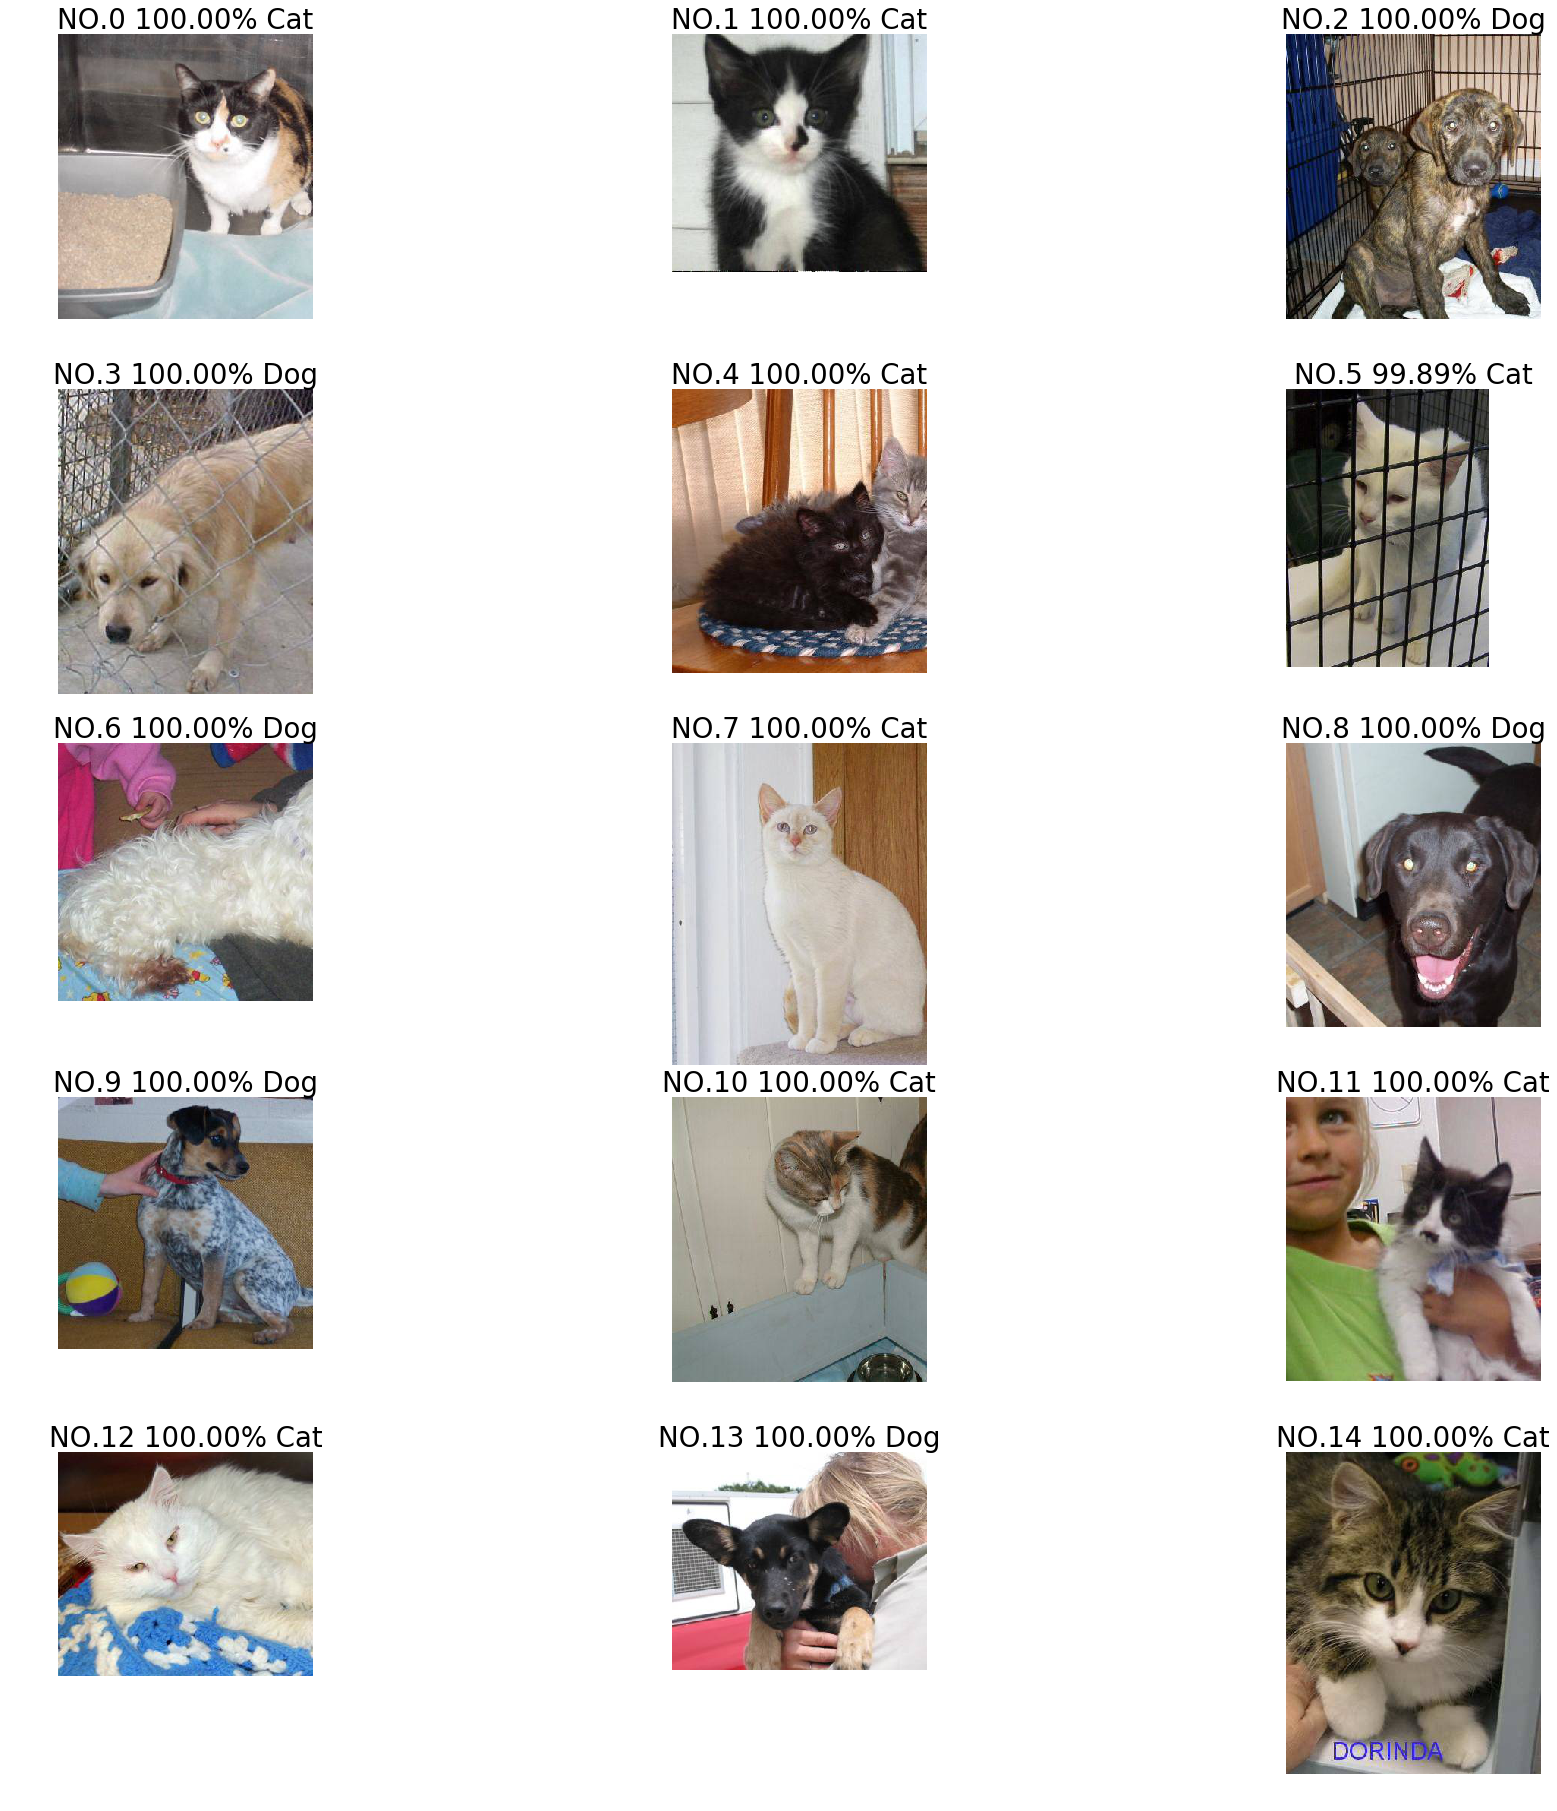

In [96]:
import matplotlib.pyplot as plt
i_dim = 3
j_dim = 5
np.random.seed(2017)
indices = np.random.randint(12500,size=i_dim*j_dim)
figure,ax=plt.subplots(j_dim,i_dim,sharex=True,sharey=True)
plt.rc('figure',figsize=(32,32))
font_option={'size':23}
plt.rc('font',**font_option)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_data_dir, shuffle=False)
figure.titlesize  = "large"
for j in range(j_dim):
    for i in range(i_dim):
        y_pred_index = indices[i_dim*j+i]
        img_file_name = test_data_dir +"/"+ test_generator.filenames[y_pred_index]
        img = Image.open(img_file_name)
        ax[j][i].axis('off') # 关掉坐标轴为 off
        rate = float(y_pred[y_pred_index])
        if rate>0.5:
            ax[j][i].set_title('NO.{} {:.2%} Dog'.format(i_dim*j+i,rate)) # 图像题目
        else:
            ax[j][i].set_title('NO.{} {:.2%} Cat'.format(i_dim*j+i,1.-rate)) # 图像题目
        ax[j][i].imshow(img)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig("pred_samples.png",dpi=200,bbox_inches="tight")